# Emotion Estimation - RAVDESS Dataset

Ujjwal Gutta - 1215350903 

In [ ]:
# Mounting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive/')
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
drive  sample_data


In [ ]:
pip install scikit-learn==0.22 librosa==0.7.1 soundfile

     |████████████████████████████████| 7.0MB 48.8MB/s 
     |████████████████████████████████| 1.6MB 49.8MB/s 
     |████████████████████████████████| 3.6MB 59.2MB/s 
  Created wheel for librosa: filename=librosa-0.7.1-cp36-none-any.whl size=1610157 sha256=6a821e94c9b5be6700186457ab63532b19b7554326aa72836441c5ecc08a99db
  Stored in directory: /root/.cache/pip/wheels/07/36/47/a9a4d151332cbdaec564500af9704a0ad862cf554dcf4bfda0
Successfully built librosa
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
  Found existing installation: numba 0.40.1
    Uninstalling numba-0.40.1:
      Successfully uninstalled numba-0.40.1
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


# Sound File Extraction

In [ ]:

import librosa
import soundfile
import os, glob, pickle
import numpy as np
#from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Extract features (mfcc, chroma, mel) from a sound file
def extract_RAVDESS_feature(file_name, mfcc,energy,zcr,flat, contrast):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        result=np.array([])
        if contrast:
            stft=np.abs(librosa.stft(X))
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if energy:
            S, phase = librosa.magphase(librosa.stft(X))
            rms = np.mean(librosa.feature.rms(S=S).T,axis=0)
            result=np.hstack((result, rms))
        if zcr:
            z =  np.mean(librosa.feature.zero_crossing_rate(X).T,axis = 0)    
            result=np.hstack((result, z))
        if flat:
            flatness = np.mean(librosa.feature.spectral_flatness(y=X).T,axis=0)
            result=np.hstack((result, flatness))    
        if contrast:
            spec_contrast=np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, spec_contrast))
        return result

In [ ]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
observed_emotions=['neutral','calm', 'happy','sad','angry', 'fearful', 'disgust','surprised']



# Feature Extraction

In [ ]:

#Load the data and extract features for each sound file
x,y=[],[]
files_loc = 'drive/My Drive/speech_trial/Actor_*/*.wav'
for file in glob.glob(files_loc):
  file_name=os.path.basename(file)
  emotion=emotions[file_name.split("-")[2]]
  if emotion not in observed_emotions:
    continue
  feature=extract_RAVDESS_feature(file, mfcc=True, energy=True,zcr=True,flat=True, contrast=True)
  x.append(feature)
  y.append(emotion)
x_train,x_test,y_train,y_test= train_test_split(np.array(x), y, test_size=0.25, random_state=None)

In [ ]:

# Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(1080, 360)
Features extracted: 50


# I. Deep Neural Network

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 63.06%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.71      0.80      0.75        45
        calm       0.67      0.86      0.75        42
     disgust       0.62      0.64      0.63        47
     fearful       0.68      0.57      0.62        56
       happy       0.64      0.48      0.55        48
     neutral       0.56      0.48      0.52        29
         sad       0.51      0.55      0.53        49
   surprised       0.63      0.66      0.64        44

    accuracy                           0.63       360
   macro avg       0.63      0.63      0.62       360
weighted avg       0.63      0.63      0.63       360



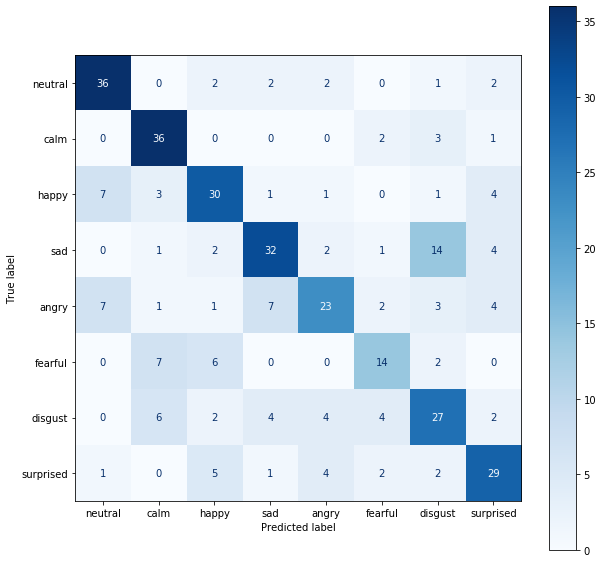

In [ ]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from google.colab import files

# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, activation='logistic',batch_size=200, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive',max_iter=500,solver='adam')

#Train the model
model.fit(x_train,y_train)
plt.rcParams['figure.figsize'] = (10, 10)

# Predict for the test set
y_pred=model.predict(x_test)

# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))
# Print the classification report
print('\nCLASSIFICATION REPORT')
report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)  

#Plot the confusion matrix
disp = plot_confusion_matrix(model, x_test, y_test,display_labels=observed_emotions,cmap=plt.cm.Blues)
# Save the confusion plot
plt.savefig("MLP-RAVDESS.png")
#files.download("MLP-RAVDESS.png") 
plt.show()


# II.(a) ML Models - Support Vector Machine

Accuracy: 58.06%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.70      0.82      0.76        45
        calm       0.50      0.76      0.60        42
     disgust       0.55      0.51      0.53        47
     fearful       0.69      0.68      0.68        56
       happy       0.56      0.52      0.54        48
     neutral       0.43      0.31      0.36        29
         sad       0.39      0.31      0.34        49
   surprised       0.72      0.66      0.69        44

    accuracy                           0.58       360
   macro avg       0.57      0.57      0.56       360
weighted avg       0.58      0.58      0.57       360



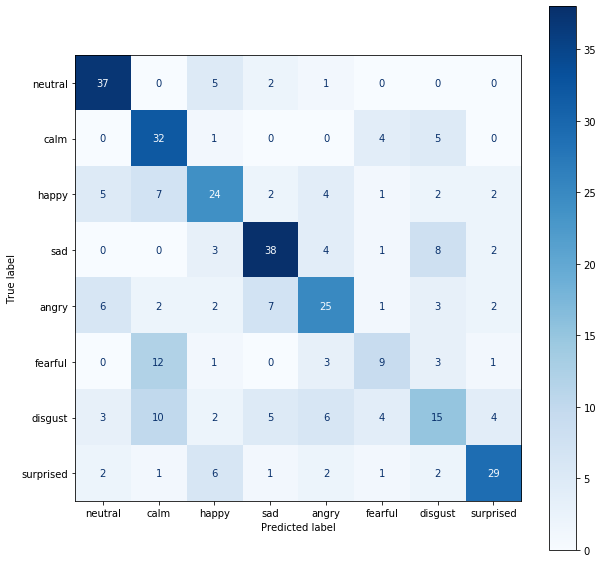

In [ ]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
model = SVC(C=1,gamma = 0.01,kernel='poly')
model.fit(x_train, y_train)

# Predict for the test set
y_pred=model.predict(x_test)

plt.rcParams['figure.figsize'] = (10, 10)


# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))
# Print the classification report
print('\nCLASSIFICATION REPORT')
report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)  
#Plot the confusion matrix
disp = plot_confusion_matrix(model, x_test, y_test,display_labels=observed_emotions,cmap=plt.cm.Blues)
plt.savefig("SVM-RAVDESS.png")
#files.download("SVM-RAVDESS.png") 
plt.show()

# II.(b) ML Models - Random Forest Classifier

Accuracy: 59.17%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry       0.80      0.71      0.75        45
        calm       0.46      0.88      0.61        42
     disgust       0.58      0.70      0.63        47
     fearful       0.61      0.48      0.54        56
       happy       0.57      0.50      0.53        48
     neutral       0.70      0.24      0.36        29
         sad       0.63      0.45      0.52        49
   surprised       0.60      0.70      0.65        44

    accuracy                           0.59       360
   macro avg       0.62      0.58      0.57       360
weighted avg       0.62      0.59      0.58       360



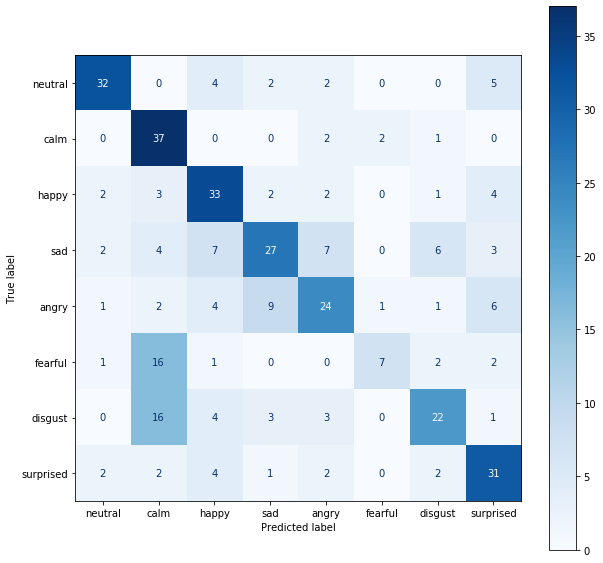

In [ ]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

# Predict for the test set
y_pred=model.predict(x_test)
plt.rcParams['figure.figsize'] = (10, 10)

# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))
# Print the classification report
print('\nCLASSIFICATION REPORT')
report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)  
#Plot the confusion matrix
disp = plot_confusion_matrix(model, x_test, y_test,display_labels=observed_emotions,cmap=plt.cm.Blues)
plt.savefig("RFC-RAVDESS.png")
#files.download("SVM-RAVDESS.png") 
plt.show()

# III. Convolutional Neural Network

In [ ]:
# Model to Implement cnn 

import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

key_list = list(emotions.keys())
value_list = list(emotions.values())
y_train_int = []
y_test_int = []
for i in range(0,x_train.shape[0]):
  temp = key_list[value_list.index(y_train[i])]
  y_train_int.append(temp)

for i in range(0,x_test.shape[0]):
  temp1 = key_list[value_list.index(y_test[i])]
  y_test_int.append(temp1)  

y_train_int = np.asarray(y_train_int)
y_test_int = np.asarray(y_test_int)

x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)


# Create the model
model = Sequential()
model.add(Conv1D(256, 5,padding='same',input_shape=(x_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(9))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
cnnhistory=model.fit(x_traincnn, y_train_int, batch_size=16, epochs=100, validation_data=(x_testcnn, y_test_int),verbose=0)

# Acquiring the predicted labels
y_pred = model.predict(x_testcnn) 
y_test_int_temp = [int(val) for val in y_test_int]
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_int_temp, y_pred=y_pred.argmax(axis=1))
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))
# Generating the confusion matrix
matrix = confusion_matrix(y_test_int_temp, y_pred.argmax(axis=1))
# Print the classification report
print('\nCLASSIFICATION REPORT')
report = sklearn.metrics.classification_report(y_test_int_temp, y_pred.argmax(axis=1))
print(report)  


Accuracy: 58.61%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       0.70      0.24      0.36        29
           2       0.50      1.00      0.67        42
           3       0.55      0.58      0.57        48
           4       0.46      0.33      0.38        49
           5       0.90      0.58      0.70        45
           6       0.62      0.55      0.58        56
           7       0.61      0.60      0.60        47
           8       0.60      0.75      0.67        44

    accuracy                           0.59       360
   macro avg       0.62      0.58      0.57       360
weighted avg       0.61      0.59      0.57       360



Text(69.0, 0.5, 'True Emotions')

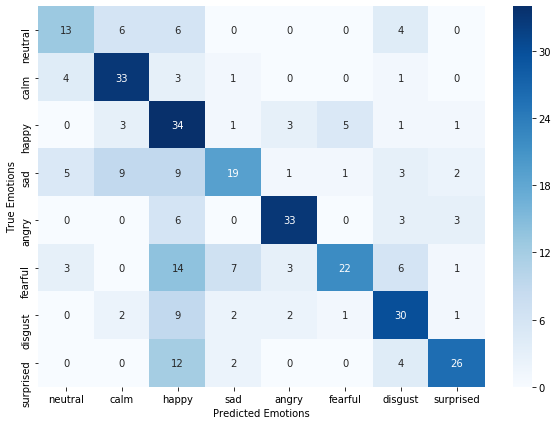

In [ ]:
# Plot the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(matrix, index = observed_emotions,
                  columns = observed_emotions)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.savefig("CNN-RAVDESS.png")
#files.download("SVM-RAVDESS.png") 
plt.xlabel('Predicted Emotions')
plt.ylabel('True Emotions')